In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations 
import random
import networkx as nx
#import EoN
from concurrent import futures
%matplotlib inline

- Create a graph made of disconnected complete subgraphs, families, with Gaussian distribution.

# 1- Half Quarantine Network Model

## $\beta$

In [280]:
%%time

is_half_quarantine = True

G = nx.Graph()
n_Of_Houses = 25000
number_of_houses_in_neighborhood = 1000
beta = 0.5
mean_of_family_size = 2.52
std_of_family_size = 1

if is_half_quarantine:
    house_white_blue_allocator = 0.02 # 0.02 for corona world. 0.93 for normal world
    ratio_of_working_people = 0.21
else:
    house_white_blue_allocator = 0.93
    ratio_of_working_people = 0.76
    
    
size_of_Houses = []
for i in range(n_Of_Houses):
    number = round(random.gauss(mean_of_family_size, std_of_family_size))
    while (number < 1):
        number = round(random.gauss(mean_of_family_size, std_of_family_size))
        
    size_of_Houses.append(number)
    if number == 1:
        G.add_node(len(G))
    else:
        for pair in list(combinations(np.arange(len(G), len(G) + number) , 2)):
            G.add_edge(pair[0], pair[1], weight = beta)
print("Is graph connected?: " + str(nx.is_connected(G)))
print("Number of components: " + str (nx.number_connected_components(G)))
print("Mean of Number of Nodes in a Component: " + str(mean_of_family_size))
print("Average Clustering Coefficient: " + str(nx.average_clustering(G)))

Is graph connected?: False
Number of components: 25000
Mean of Number of Nodes in a Component: 2.52
Average Clustering Coefficient: 0.6801489411217129
Wall time: 1.96 s


In [281]:
%%time
# List of Nodes and Houses
nodes = list(G.nodes())
df = pd.DataFrame(nodes)
df.columns = ['Node']

lst = []
for i in range(len(size_of_Houses)):
    for j in range(size_of_Houses[i]):
        lst.append(i)
        
df['House'] = lst

house_List = np.arange(0, len(size_of_Houses), 1)

# WHITE-BLUE
lst_White = []
white_blue_likelihood = 0.8
for house in size_of_Houses:
    is_White = np.random.rand() > house_white_blue_allocator
    
    for i in range(house):
        if is_White:
            lst_White.append(np.random.rand() < white_blue_likelihood)
        else:
            lst_White.append(np.random.rand() < (1 - white_blue_likelihood))
            
df['isWhite'] = lst_White

# Send people to work
df['Work'] = -1

lst_of_jobs = []
mean_of_job_size = 10
std_of_job_size = 5
while np.sum(lst_of_jobs) < df[df['isWhite'] == False].shape[0]:
    job_size = round(random.gauss(mean_of_job_size, std_of_job_size))
    if job_size < 2:
        continue
    lst_of_jobs.append(job_size)
df_jobs = pd.DataFrame(lst_of_jobs).reset_index()
df_jobs.columns = ['Job', 'No_of_Ppl']

l = int(number_of_houses_in_neighborhood * mean_of_family_size / 2)

mean_of_job_allocator = 0
std_of_job_allocator = df_jobs.shape[0] / 4


for node in df[df['isWhite'] == False]['Node'].values:
    list_of_available_jobs = df_jobs[df_jobs['No_of_Ppl'] != 0]['Job'].values
    corresponding_job_for_node = (node * ratio_of_working_people) / mean_of_job_size
    job_allocation = min(list_of_available_jobs, key=lambda x:abs(x - (corresponding_job_for_node + round(random.gauss(mean_of_job_allocator, std_of_job_allocator)))))
    df_jobs.iloc[job_allocation, 1] -= 1
    df.iloc[node, 3] = job_allocation
    
# Add edges with  𝛽  for people at same work

df_workers = df[df['isWhite'] == False]
for item in df_workers[['Node', 'Work']].groupby('Work'):
    for pair in list(combinations(item[1]['Node'].values , 2)):
        G.add_edge(pair[0], pair[1], weight = beta)
        
print("Is graph connected?: " + str(nx.is_connected(G)))
c = [list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
lst_of_sizes_of_c = []
for comp in c:
    lst_of_sizes_of_c.append(len(comp))
print("Number of Components: " + str(len(c)))
print("Mean of Number of Nodes in a Component: " + str(np.mean(lst_of_sizes_of_c)))
print("Average Clustering Coefficient: " + str(nx.average_clustering(G)))

Is graph connected?: False
Number of Components: 14263
Mean of Number of Nodes in a Component: 4.519035266073056
Average Clustering Coefficient: 0.6886030286831888
Wall time: 1min


## $\beta^{2}$

- 50 % of Blue group are service industry such as couriers, market cashiers, etc that have to interact with a lot of people daily.
- They are connected to 5% of the neighborhood where their work is at.

In [282]:
%%time
if is_half_quarantine:
    ratio_of_service_industry = 0.50
else:
    ratio_of_service_industry = 0.33
ratio_of_connections_for_service_industry = 0.05
servers = df[df['isWhite'] == False].sample(frac = ratio_of_service_industry)['Node'].values

for server in servers:
    servers_corresponding_node_in_work_neighborhood = int((df.loc[server, 'Work'] * mean_of_job_size) / ratio_of_working_people)
    to_be_served_by_current_server = df.iloc[servers_corresponding_node_in_work_neighborhood - l:servers_corresponding_node_in_work_neighborhood + l, :].sample(frac = ratio_of_connections_for_service_industry)['Node'].values
    for to_be_served in to_be_served_by_current_server:
        if G.has_edge(server, to_be_served) == False:
            G.add_edge(server, to_be_served, weight = beta ** 2)

print("Is graph connected?: " + str(nx.is_connected(G)))
c = [list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
lst_of_sizes_of_c = []
for comp in c:
    lst_of_sizes_of_c.append(len(comp))
print("Number of Components: " + str(len(c)))
print("Mean of Number of Nodes in a Component: " + str(np.mean(lst_of_sizes_of_c)))
print("Average Clustering Coefficient: " + str(nx.average_clustering(G)))

Is graph connected?: False
Number of Components: 140
Mean of Number of Nodes in a Component: 460.39285714285717
Average Clustering Coefficient: 0.07133623448321635
Wall time: 34.7 s


- People not only interact with people at work, or Blue group in service industry but also have small interactions with random people within neighborhood either by passing by in street, market, pharmacy line, etc.
- Number of randomly contacted people is also determined for each person, according to Gaussian distribution

## $\beta^{3}$

In [292]:
%%time
mean_of_b_3_connections = int(number_of_houses_in_neighborhood * mean_of_family_size *  0.02)
std_of_b_3_connections = mean_of_b_3_connections / 2
for node in df['Node'].values:
    
    number_of_b_3_connections = max(0, round(random.gauss(mean_of_b_3_connections, std_of_b_3_connections)))
    b_3_list = df.iloc[max(0, node-l):node+l, 0].sample(number_of_b_3_connections).values

    for random_person in b_3_list:
        if G.has_edge(node, random_person) == False:
            G.add_edge(node, random_person, weight = beta**3)         
            
print("Is graph connected?: " + str(nx.is_connected(G)))
c = [list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
lst_of_sizes_of_c = []
for comp in c:
    lst_of_sizes_of_c.append(len(comp))
print("Number of Components: " + str(len(c)))
print("Mean of Number of Nodes in a Component: " + str(np.mean(lst_of_sizes_of_c)))
print("Average Clustering Coefficient: " + str(nx.average_clustering(G)))

Is graph connected?: True
Number of Components: 1
Mean of Number of Nodes in a Component: 64455.0
Average Clustering Coefficient: 0.03592646601109888
Wall time: 3min 43s


In [113]:
%%time
nx.diameter(G)

Wall time: 2min 25s


26

In [293]:
nx.write_gpickle(G, "Half_Quarantine_Graph_USA.gpickle")

In [294]:
df.to_csv('df_Half_Quarantine_Graph_USA.csv')

# 2- World Before Covid-19 Model

## Friendship Relation

- Each person has a number of friends with Gaussian distribution
- Their location in the graph can be anywhere with mean 0
- To have a wide range, std of friend location in the graph will be number of Nodes / 4.

In [ ]:
%%time
df['Number_of_Friends_so_far'] = 0
df['Number_of_Friends_defined'] = 0
mean_of_number_of_friends = 6.5
std_of_number_of_friends = 3
lst_friendlist = []
for node in df['Node'].values:
    number_of_friends = max(0, round(random.gauss(mean_of_number_of_friends, std_of_number_of_friends)))
    df.loc[node, 'Number_of_Friends_defined'] = number_of_friends

while df[df['Number_of_Friends_so_far'] < df['Number_of_Friends_defined']].shape[0]>1:
    node = df[df['Number_of_Friends_so_far'] < df['Number_of_Friends_defined']]['Node'].sample(1).values[0]
    #friendlist_of_node = ""
    while df.loc[node, 'Number_of_Friends_so_far'] < df.loc[node, 'Number_of_Friends_defined']:
        some_std = max(0, round(random.gauss(0, df.shape[0] / 2 )))
        while df[df['Number_of_Friends_so_far'] < df['Number_of_Friends_defined']].iloc[max(0, node - (l + some_std)): node + (l + some_std)].shape[0] < 1:
            some_std = (some_std + 5)*2
        friendNode = df[df['Number_of_Friends_so_far'] < df['Number_of_Friends_defined']].iloc[max(0, node - (l + some_std)): node + (l + some_std)]['Node'].sample(1).values[0]
        if df.loc[friendNode, 'Number_of_Friends_so_far'] < df.loc[friendNode, 'Number_of_Friends_defined']:
            df.loc[node, 'Number_of_Friends_so_far'] += 1
            df.loc[friendNode, 'Number_of_Friends_so_far'] += 1
            G.add_edge(node, friendNode, weight = beta)       
    
    # Weak interactions, 10x the number of friends, 10% being beta**2
    nodes_of_weak_interactions = df['Node'].sample(10 * number_of_friends).values
    for weak_interaction_node in nodes_of_weak_interactions:
        if np.random.rand() < 0.1:
            if G.has_edge(node, weak_interaction_node) == False:
                G.add_edge(node, weak_interaction_node, weight = beta**2)      
        else:
            if G.has_edge(node, weak_interaction_node) == False:
                G.add_edge(node, weak_interaction_node, weight = beta**3)


In [ ]:
nx.write_gpickle(G, "World_Before_COVID19_Graph_USA.gpickle")

In [ ]:
df.to_csv('df_World_Before_COVID19_Graph_USA.csv')

## EoN SIR

In [98]:
%%time
lst = []
gamma = 0
for i in range(100): 
    df3 = EoN.fast_SIR(G, tau = 1, gamma = gamma, initial_infecteds = 0, return_full_data = True)
    lst.append(df3.t()[-1])

Wall time: 917 ms


In [99]:
np.mean(lst)

499.78462768519995

(array([ 1., 13., 28., 25., 19.,  9.,  3.,  1.,  0.,  1.]),
 array([0.98883507, 1.12690753, 1.26498   , 1.40305246, 1.54112493,
        1.67919739, 1.81726986, 1.95534233, 2.09341479, 2.23148726,
        2.36955972]),
 <a list of 10 Patch objects>)

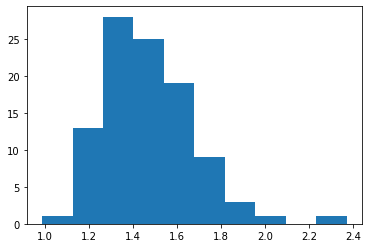

In [86]:
plt.hist(lst)

- Add edges with $\beta$ for people at same work

In [ ]:
b1-b2-b3 ile:1.45 başka denemede 1.42
hepsi b1 ile:

In [ ]:
b2-b3 olanların hepsini b yapıp öyle dene

#### Adjacency List with Weights

In [458]:
df2 = pd.DataFrame(G.edges.data('weight', default=1))
df2.columns = ['u', 'v', 'weight']

#### Node Status Post Run

In [88]:
df4 = pd.DataFrame(df3.get_statuses(G.nodes, df3.t()[-1]), index = [0]).T

In [89]:
df4[0].value_counts()

I    3495
Name: 0, dtype: int64

In [92]:
pd.DataFrame(G.degree).mean()

0    1747.000000
1     106.302146
dtype: float64

- Investigation of Nodes and mean of Node's Friends

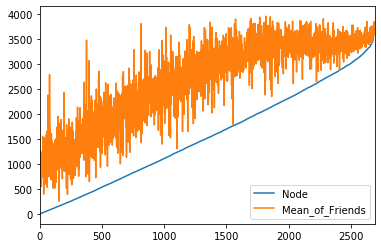

In [134]:
lst_of_nodes = []
lst_of_means = []
for node in df[df['Friend_List'] != ""]['Node'].values:
    lst_of_nodes.append(node)
    friendlist = df.loc[node, 'Friend_List'].split(",")
    friendlist = np.array(friendlist[0: len(friendlist)-1]).astype(int)
    lst_of_means.append(np.mean(friendlist))
df2 = pd.DataFrame({'Node': lst_of_nodes, 'Mean_of_Friends': lst_of_means})
df2.plot()

## Future work

- Benim planım böyle bir network'ün nasıl bir yapısı var onu, network'u özetleyen parametreler açısından incelemek. Fakat eklediğim $\beta^{n}$ zayıf edge'ler network yapısını bu anlamda complete'e yaklaştırıyor gibi. Belki yalnızca beta'lı halini mi incelemek gerekir? Yakın zamanda modularity'i gördük. Bunun dışında nelere bakmak lazım?

- Bu varsıyamlarla yaratılmış modele ne ekleyebilirim?

- Ardından planım normal zamanı simüle etmek için çalışan nüfusun oranını %75-80'lere çekip bir de arkadaşlarla buluşmayı, restoran, bar gibi yerlere gitmeyi dahil etmek. Bu ikisi üzerinde SIR tipi yayılım yapıp zaman açısından nasıl farklar olur buna bakmak.

- Farklı beta değerleri için toplumun yüzde kaçına gidiyor, %100e ulaşan beta değeri nedir? Böyle bir kritik beta değeri var mı?
- %100e kadar giderken süre nasıl değişiyor?
- Weighted graph'ta hangi metric'ler işe yarar? Mürsel clustering coeff'i weighted graph'ta tanımlamıştı. O çalışmaya bakabilirim.
- Node degree'yi edge'lerin weight'lerini toplayıp beta'ya bölerek, normalize edilmiş halde daha iyi bulabilirim

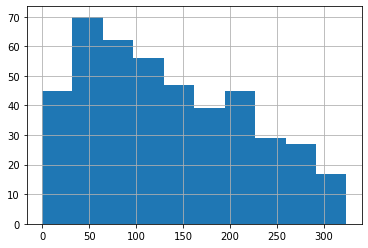

In [295]:
df[df['isWhite'] == False].iloc[l: l + int(l/2), 3].hist()